In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import trange, notebook
from odeintw import odeintw
from scipy.integrate import solve_ivp


#  define system of motion equations 
def diff_eq(z, t):
    q, p = z
    return [p, F*np.cos(OMEGA * t) + Fm*np.cos(3*OMEGA * t) - 2*gamma*p + k*omega0**2 * q - beta * q**3]


def motion_analytical(t, x0, p0, omega0, gamma, F, Fm, OMEGA):
    import numpy
    
    #  linear spectrum
    if gamma == 0:
        omega = omega0
        
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        C1 = 6*gamma*OMEGA*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        D1 = (omega0**2 - 9*OMEGA**2)*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        
        A = x0 - D - D1
        B = (p0 - C*OMEGA - 3*C1*OMEGA) / omega
        
        return [A * np.cos(omega * t) + B*np.sin(omega*t) + 
                D*np.cos(OMEGA*t) + C*np.sin(OMEGA*t)+ D1*np.cos(3*OMEGA*t) + C1*np.sin(3*OMEGA*t),
               -omega*A * np.sin(omega * t) + B*omega*np.cos(omega*t) - OMEGA*D*np.sin(OMEGA*t) 
                + OMEGA*C*np.cos(OMEGA*t) - 
               3*OMEGA*C1*np.sin(3*OMEGA*t) + 3*OMEGA*D1*np.cos(3*OMEGA*t)]
    
    #  gamma < w0
    elif gamma < omega0 and F == 0 and Fm == 0:
        omega = np.sqrt(omega0**2 - gamma**2)
        return [np.exp(-gamma*t) * ( x0*np.cos(omega*t) + (p0 + gamma*x0)/omega*np.sin(omega*t)),
               -gamma*np.exp(-gamma*t) * ( x0*np.cos(omega*t) + (p0 + gamma*x0)/omega*np.sin(omega*t)) + 
               omega*np.exp(-gamma*t) * ( -x0*np.sin(omega*t) + (p0 + gamma*x0)/omega*np.cos(omega*t))]
    
    #  gamma > w0
    elif gamma > omega0 and F == 0 and Fm == 0:
        omega = np.sqrt(gamma**2 - omega0**2  )
        return [np.exp(-gamma*t + omega*t) * ( x0/2 + (gamma*x0 + p0)/(2*omega) ) + 
                np.exp(-gamma*t - omega*t) * ( x0/2 - (gamma*x0 + p0)/(2*omega)),
                (omega - gamma)*np.exp(-gamma*t + omega*t) * ( x0/2 + (gamma*x0 + p0)/(2*omega) ) - 
                (omega + gamma)*np.exp(-gamma*t - omega*t) * ( x0/2 - (gamma*x0 + p0)/(2*omega) )]
    
    #  gamma = w0
    elif gamma == omega0 and F == 0 and Fm == 0:
        omega = np.sqrt(gamma**2 - omega0**2  )
        return [( x0 + (gamma*x0 + p0)*t ) * np.exp(-gamma*t),
               -gamma*( x0 + (gamma*x0 + p0)*t ) * np.exp(-gamma*t) + (p0 + gamma*x0)*np.exp(-gamma*t)]
    
    
    #  gamma < w0 with force F
    elif gamma < omega0 and F > 0 and Fm == 0:
        omega = np.sqrt(omega0**2 - gamma**2)
        
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)

        A = x0 - D
        B = (p0 + gamma*x0 - gamma*D - C*OMEGA) / (omega)
    
        return [np.exp(-gamma*t) * (A*np.cos(omega*t) + B*np.sin(omega*t)) + 
                D*np.cos(OMEGA*t) + C*np.sin(OMEGA*t),
           -gamma*np.exp(-gamma*t) * (A*np.cos(omega*t) + B*np.sin(omega*t))
           +np.exp(-gamma*t) * (-A*np.sin(omega*t) + B*np.cos(omega*t)) -
               OMEGA*D*np.sin(OMEGA*t) + OMEGA*C*np.cos(OMEGA*t)]
    
    
    
    #  gamma > w0 with force F
    elif gamma > omega0 and F > 0 and Fm == 0:
        omega = np.sqrt(-omega0**2 + gamma**2)
        
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        
        B = ( x0*(omega - gamma) + D*(gamma - omega) + C*OMEGA - p0 ) /(2*omega)
        A = x0 - B - D
        
        return [A*np.exp((-gamma + omega)*t) + B*np.exp(-(gamma + omega)*t) + 
                D*np.cos(OMEGA*t) + C*np.sin(OMEGA*t),
            (-gamma + omega)*A*np.exp((-gamma + omega)*t) -
                (gamma + omega)*B*np.exp(-(gamma + omega)*t) -
               OMEGA*D*np.sin(OMEGA*t) + OMEGA*C*np.cos(OMEGA*t)]
    
    
    #  gamma = w0 with force F
    elif gamma == omega0 and F > 0 and Fm == 0:
        omega = np.sqrt(omega0**2 - gamma**2)
        
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        A = x0 - D
        B = p0 + gamma*x0 - gamma*D - C*OMEGA
        
        return [(A+B*t)*np.exp(-gamma*t) + D*np.cos(OMEGA*t) + C*np.sin(OMEGA*t),
                -gamma*(A+B*t)*np.exp(-gamma*t) + B*np.exp(-gamma*t) -
               OMEGA*D*np.sin(OMEGA*t) + OMEGA*C*np.cos(OMEGA*t)]
    
    
    #  gamma < w0 with two forces F and Fm
    elif gamma < omega0 and F > 0 and Fm > 0:
        omega = np.sqrt(omega0**2 - gamma**2)
        
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        C1 = 6*gamma*OMEGA*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        D1 = (omega0**2 - 9*OMEGA**2)*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        
        A = x0 - D - D1
        B = (p0 + gamma*x0 - gamma*D - gamma*D1 - C*OMEGA - 3*C1*OMEGA) / (omega)
    
        return [np.exp(-gamma*t) * (A*np.cos(omega*t) + B*np.sin(omega*t)) + 
                D*np.cos(OMEGA*t) + C*np.sin(OMEGA*t) + D1*np.cos(3*OMEGA*t) + C1*np.sin(3*OMEGA*t),
           -gamma*np.exp(-gamma*t) * (A*np.cos(omega*t) + B*np.sin(omega*t))
           +np.exp(-gamma*t) * (-A*omega*np.sin(omega*t) + B*omega*np.cos(omega*t)) -
               OMEGA*D*np.sin(OMEGA*t) + OMEGA*C*np.cos(OMEGA*t) -
                3*OMEGA*D1*np.sin(3*OMEGA*t) + 3*OMEGA*C1*np.cos(3*OMEGA*t)]
    
    
    #  gamma > w0 with two forces F and Fm
    elif gamma > omega0 and F > 0 and Fm > 0:
        omega = np.sqrt(-omega0**2 + gamma**2)
        
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        C1 = 6*gamma*OMEGA*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        D1 = (omega0**2 - 9*OMEGA**2)*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        
        B = ( x0*(omega - gamma) + D*(gamma - omega) + 3*D1*(gamma - omega) +
             C*OMEGA + 3*C1*OMEGA - p0 ) /(2*omega)
        A = x0 - B - D - D1
        
        return [A*np.exp((-gamma + omega)*t) + B*np.exp(-(gamma + omega)*t) + 
                D*np.cos(OMEGA*t) + C*np.sin(OMEGA*t) + D1*np.cos(3*OMEGA*t) + C1*np.sin(3*OMEGA*t),
                (-gamma + omega)*A*np.exp((-gamma + omega)*t) -
                (gamma + omega)*B*np.exp(-(gamma + omega)*t) - 
               OMEGA*D*np.sin(OMEGA*t) + OMEGA*C*np.cos(OMEGA*t) - 
               3*OMEGA*C1*np.sin(3*OMEGA*t) + 3*OMEGA*D1*np.cos(3*OMEGA*t)]
    
    
    #  gamma = w0 with two forces F and Fm
    elif gamma == omega0 and F > 0 and Fm > 0:
        omega = np.sqrt(-omega0**2 + gamma**2)
        
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        C1 = 6*gamma*OMEGA*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        D1 = (omega0**2 - 9*OMEGA**2)*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        
        A = x0 - D - D1
        B = p0 + gamma*x0 - gamma*D - C*OMEGA - gamma*D1 - C1*OMEGA*3
        
        return [( A + B*t ) * np.exp(-gamma*t) +
                D*np.cos(OMEGA*t) + C*np.sin(OMEGA*t)+ D1*np.cos(3*OMEGA*t) + C1*np.sin(3*OMEGA*t),
               -gamma*( A + B*t ) * np.exp(-gamma*t) + B*np.exp(-gamma*t) - 
               OMEGA*D*np.sin(OMEGA*t) + OMEGA*C*np.cos(OMEGA*t) - 
               3*OMEGA*C1*np.sin(3*OMEGA*t) + 3*OMEGA*D1*np.cos(3*OMEGA*t)]
    
    
def spectrum_density_analytical(w1, x0, p0, omega0, gamma, F, Fm, OMEGA):
    
    #  linear spectrum
    if gamma == 0:
        omega = omega0
        
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        C1 = 6*gamma*OMEGA*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        D1 = (omega0**2 - 9*OMEGA**2)*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        
        A = x0 - D - D1
        B = (p0 - C*OMEGA - 3*C1*OMEGA) / omega
        
        x_w1 =  ( B * omega * ( ( ( omega )**( 2 ) + -1 * ( w1 )**( 2 ) ) )**( -1 ) + \
        ( complex( 0,1 ) * A * w1 * ( ( ( omega )**( 2 ) + -1 * ( w1 )**( 2 ) \
        ) )**( -1 ) + ( C * OMEGA * ( ( ( OMEGA )**( 2 ) + -1 * ( w1 )**( 2 ) \
        ) )**( -1 ) + ( complex( 0,1 ) * D * w1 * ( ( ( OMEGA )**( 2 ) + -1 * \
        ( w1 )**( 2 ) ) )**( -1 ) + ( 3 * C1 * OMEGA * ( ( 9 * ( OMEGA )**( 2 \
        ) + -1 * ( w1 )**( 2 ) ) )**( -1 ) + complex( 0,-1 ) * D1 * w1 * ( ( \
        -9 * ( OMEGA )**( 2 ) + ( w1 )**( 2 ) ) )**( -1 ) ) ) ) ) )
        
        return abs(x_w1)**2
    
    #  gamma < w0
    elif gamma < omega0 and F == 0 and Fm == 0:
        omega = np.sqrt(omega0**2 - gamma**2)
        x_w1 = ( ( ( omega )**( 2 ) + ( ( gamma + complex( 0,1 ) * w1 ) )**( 2 ) ) \
            )**( -1 ) * ( p0 + ( 2 * gamma * x0 + complex( 0,1 ) * w1 * x0 ) )
        return abs(x_w1)**2
    
    #  gamma > w0
    elif gamma > omega0 and F == 0 and Fm == 0:
        omega = np.sqrt(gamma**2 - omega0**2  )
        x_w1 = 1/2 * ( ( gamma + -1 * omega ) )**( -1 ) * ( omega )**( -1 ) * ( ( \
            gamma + ( omega + complex( 0,1 ) * w1 ) ) )**( -1 ) * ( complex( 0,1 \
                ) * w1 * ( p0 + gamma * x0 ) + omega * ( 2 * p0 + ( 4 * gamma * x0 + \
                    complex( 0,1 ) * w1 * x0 ) ) )
        return abs(x_w1)**2
    
    #  gamma = w0
    elif gamma == omega0 and F == 0 and Fm == 0:
        omega = np.sqrt(gamma**2 - omega0**2  )
        x_w1 = ( ( gamma + complex( 0,1 ) * w1 ) )**( -2 ) * ( p0 + ( 2 * gamma * x0 \
        + complex( 0,1 ) * w1 * x0 ) )
        return abs(x_w1)**2
    
    
    #  gamma < w0 with force F
    elif gamma < omega0 and F > 0 and Fm == 0:
        omega = np.sqrt(omega0**2 - gamma**2)
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)

        A = x0 - D
        B = (p0 + gamma*x0 - gamma*D - C*OMEGA) / (omega)
        x_w1 = ( B * omega * ( ( ( omega )**( 2 ) + ( ( gamma + complex( 0,1 ) * w1 \
        ) )**( 2 ) ) )**( -1 ) + ( A * ( ( ( omega )**( 2 ) + ( ( gamma + \
        complex( 0,1 ) * w1 ) )**( 2 ) ) )**( -1 ) * ( gamma + complex( 0,1 ) \
        * w1 ) + ( ( ( OMEGA )**( 2 ) + ( ( gamma + complex( 0,1 ) * w1 ) \
        )**( 2 ) ) )**( -1 ) * ( D * gamma + ( C * OMEGA + complex( 0,1 ) * D \
        * w1 ) ) ) )
        return abs(x_w1)**2
    
    
    #  gamma > w0 with force F
    elif gamma > omega0 and F > 0 and Fm == 0:
        omega = np.sqrt(-omega0**2 + gamma**2)
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        
        B = ( x0*(omega - gamma) + D*(gamma - omega) + C*OMEGA - p0 ) /(2*omega)
        A = x0 - B - D
        x_w1 = ( A * ( ( gamma + ( -1 * omega + complex( 0,1 ) * w1 ) ) )**( -1 ) + \
        ( B * ( ( gamma + ( omega + complex( 0,1 ) * w1 ) ) )**( -1 ) + ( C * \
        OMEGA + complex( 0,1 ) * D * w1 ) * ( ( ( OMEGA )**( 2 ) + -1 * ( w1 \
        )**( 2 ) ) )**( -1 ) ) )
        return abs(x_w1)**2
    
    
    #  gamma = w0 with force F
    elif gamma == omega0 and F > 0 and Fm == 0:
        omega = np.sqrt(omega0**2 - gamma**2)
        
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        A = x0 - D
        B = p0 + gamma*x0 - gamma*D - C*OMEGA
        
        x_w1 = ( ( B + A * ( gamma + complex( 0,1 ) * w1 ) ) * ( ( gamma + complex( \
        0,1 ) * w1 ) )**( -2 ) + ( C * OMEGA + complex( 0,1 ) * D * w1 ) * ( \
        ( ( OMEGA )**( 2 ) + -1 * ( w1 )**( 2 ) ) )**( -1 ) )
        return abs(x_w1)**2
    
    
    #  gamma < w0 with two forces F and Fm
    elif gamma < omega0 and F > 0 and Fm > 0:
        omega = np.sqrt(omega0**2 - gamma**2)
        
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        C1 = 6*gamma*OMEGA*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        D1 = (omega0**2 - 9 *OMEGA**2)*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        
        A = x0 - D - D1
        B = (p0 + gamma*x0 - gamma*D - gamma*D1 - C*OMEGA - 3*C1*OMEGA) / (omega)
        
        x_w1 = ( B * omega * ( ( ( omega )**( 2 ) + ( ( gamma + complex( 0,1 ) * w1 \
        ) )**( 2 ) ) )**( -1 ) + ( A * ( ( ( omega )**( 2 ) + ( ( gamma + \
        complex( 0,1 ) * w1 ) )**( 2 ) ) )**( -1 ) * ( gamma + complex( 0,1 ) \
        * w1 ) + ( ( ( ( OMEGA )**( 2 ) + ( ( gamma + complex( 0,1 ) * w1 ) \
        )**( 2 ) ) )**( -1 ) * ( D * gamma + ( C * OMEGA + complex( 0,1 ) * D \
        * w1 ) ) + ( ( 9 * ( OMEGA )**( 2 ) + ( ( gamma + complex( 0,1 ) * w1 \
        ) )**( 2 ) ) )**( -1 ) * ( D1 * gamma + ( 3 * C1 * OMEGA + complex( \
        0,1 ) * D1 * w1 ) ) ) ) )
        return abs(x_w1)**2
    
    
    #  gamma > w0 with two forces F and Fm
    elif gamma > omega0 and F > 0 and Fm > 0:
        omega = np.sqrt(-omega0**2 + gamma**2)
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        C1 = 6*gamma*OMEGA*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        D1 = (omega0**2 - 9*OMEGA**2)*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        
        B = ( x0*(omega - gamma) + D*(gamma - omega) + 3*D1*(gamma - omega) +
             C*OMEGA + 3*C1*OMEGA - p0 ) /(2*omega)
        A = x0 - B - D - D1
        
        x_w1 = ( A * ( ( gamma + ( -1 * omega + complex( 0,1 ) * w1 ) ) )**( -1 ) + \
        ( B * ( ( gamma + ( omega + complex( 0,1 ) * w1 ) ) )**( -1 ) + ( C * \
        OMEGA * ( ( ( OMEGA )**( 2 ) + -1 * ( w1 )**( 2 ) ) )**( -1 ) + ( \
        complex( 0,1 ) * D * w1 * ( ( ( OMEGA )**( 2 ) + -1 * ( w1 )**( 2 ) ) \
        )**( -1 ) + ( 3 * C1 * OMEGA + complex( 0,1 ) * D1 * w1 ) * ( ( 9 * ( \
        OMEGA )**( 2 ) + -1 * ( w1 )**( 2 ) ) )**( -1 ) ) ) ) )
        return abs(x_w1)**2
    
    
    #  gamma = w0 with two forces F and Fm
    elif gamma == omega0 and F > 0 and Fm > 0:
        omega = np.sqrt(-omega0**2 + gamma**2)
        
        C = 2*gamma*OMEGA*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        D = (omega0**2 - OMEGA**2)*F/((omega0**2 - OMEGA**2)**2 + 4*gamma**2*OMEGA**2)
        C1 = 6*gamma*OMEGA*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        D1 = (omega0**2 - 9*OMEGA**2)*Fm/((omega0**2 - 9*OMEGA**2)**2 + 36*gamma**2*OMEGA**2)
        
        A = x0 - D - D1
        B = p0 + gamma*x0 - gamma*D - C*OMEGA - gamma*D1 - C1*OMEGA*3
        
        x_w1 = ( B * ( ( gamma + complex( 0,1 ) * w1 ) )**( -2 ) + ( A * ( ( gamma + \
        complex( 0,1 ) * w1 ) )**( -1 ) + ( C * OMEGA * ( ( ( OMEGA )**( 2 ) \
        + -1 * ( w1 )**( 2 ) ) )**( -1 ) + ( complex( 0,1 ) * D * w1 * ( ( ( \
        OMEGA )**( 2 ) + -1 * ( w1 )**( 2 ) ) )**( -1 ) + ( 3 * C1 * OMEGA + \
        complex( 0,1 ) * D1 * w1 ) * ( ( 9 * ( OMEGA )**( 2 ) + -1 * ( w1 \
        )**( 2 ) ) )**( -1 ) ) ) ) )
        return abs(x_w1)**2

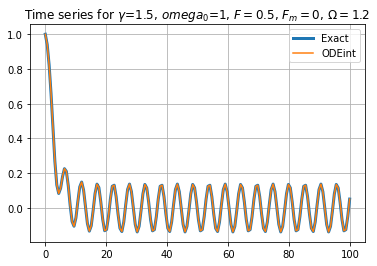

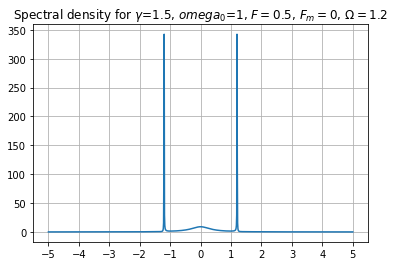

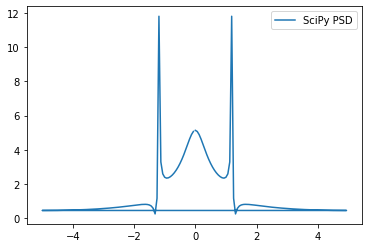

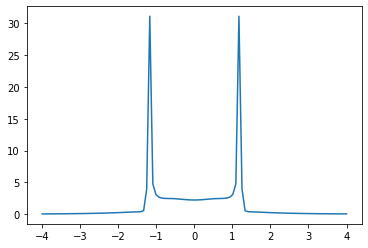

In [4]:
#  linear for beta = 0
#  analytical
x0 = 1
p0 = 0
omega0 = 1
gamma = 1.5
F = 0.5
Fm = 0
OMEGA = 1.2

t = np.arange(0, 100, 0.1*2*np.pi/omega)
plt.plot(t, motion_analytical(t, x0, p0, omega0, gamma, F, Fm, OMEGA)[0],label='Exact', lw=3)

#  numerical
T = 1 / OMEGA
k = -1
beta = 0.0

z0 = [x0, p0]
sol1 = odeintw(diff_eq, z0, t, atol=1e-13, rtol=1e-13, mxstep=1000)
num_q, num_p = sol1[:, 0], sol1[:, 1]
a = plt.plot(t, num_q, label='ODEint')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()
#plt.xlim([10, 20])
plt.title('Time series for $\gamma$=' + str(gamma) + ', $omega_0$=' + str(omega) + ', $F=$' + str(F) +
         ', $F_m=$' + str(Fm) + ', $\Omega=$' + str(OMEGA))
plt.grid()
plt.show()

#  spectral density
#  analytical
ww = np.linspace(-5, 5, 1000)
plt.plot(ww, spectrum_density_analytical(ww, x0, p0, omega0, gamma, F, Fm, OMEGA), label='Exact PSD')
plt.xticks(np.arange(min(ww), max(ww)+1, 1.0))
plt.title('Spectral density for $\gamma$=' + str(gamma) + ', $omega_0$=' + str(omega) + ', $F=$' + str(F) +
         ', $F_m=$' + str(Fm) + ', $\Omega=$' + str(OMEGA))
plt.grid()
plt.show()

#  numerical
signal = num_q
fourier = np.fft.fft(signal)
n = signal.size
timestep = 0.1
freq = np.fft.fftfreq(n, d=timestep)
plt.plot(freq, abs(fourier), label='SciPy PSD')
plt.legend()
plt.show()

def psd(w1):
    return abs(( ( OMEGA + -1 * w1 ) )**( -1 ) * ( ( OMEGA + w1 ) )**( -1 ) * ( ( complex( \
0,-1 ) * ( omega0 )**( 2 ) + ( gamma + complex( 0,1 ) * w1 ) * w1 ) )**( \
-1 ) * ( F * w1 + complex( 0,-1 ) * ( OMEGA + -1 * w1 ) * ( OMEGA + w1 ) * ( \
p0 + ( gamma + complex( 0,1 ) * w1 ) * x0 ) ))**2

w1w = np.linspace(-4, 4, 100)
plt.plot(w1w, psd(w1w))

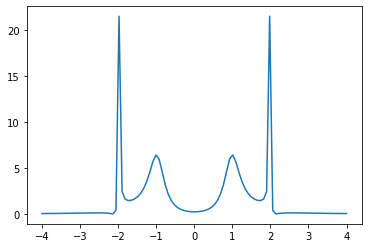

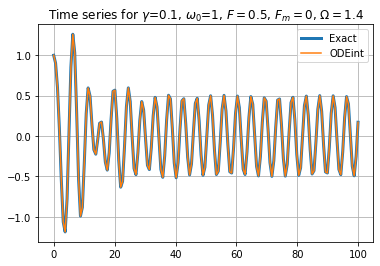

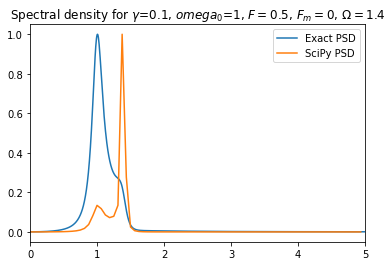

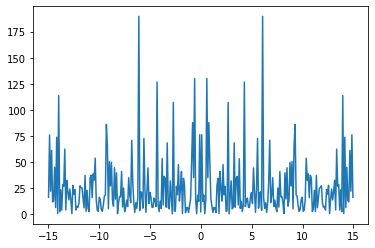

In [370]:
#  линейный осциллятор с трением gamma < omega0
#  analytical
x0 = 1
p0 = 0
omega0 = 1
gamma = 0.1
F = 0.5
Fm = 0
OMEGA = 1.4

T = 1 / OMEGA
k = -1
beta = 0.1

t = np.arange(0, 100, 0.1*2*np.pi/omega)
plt.plot(t, motion_analytical(t, x0, p0, omega0, gamma, F, Fm, OMEGA)[0],label='Exact', lw=3)

#  numerical
T = 1 / OMEGA
k = -1
beta = 0.0

z0 = [x0, p0]
sol1 = odeintw(diff_eq, z0, t, atol=1e-13, rtol=1e-13, mxstep=1000)
num_q, num_p = sol1[:, 0], sol1[:, 1]
a = plt.plot(t, num_q, label='ODEint')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()
#plt.xlim([10, 20])
plt.title('Time series for $\gamma$=' + str(gamma) + ', $\omega_0$=' + str(omega) + ', $F=$' + str(F) +
         ', $F_m=$' + str(Fm) + ', $\Omega=$' + str(OMEGA))
plt.grid()
plt.show()

#  spectral density
#  analytical
ww = np.linspace(0, 5, 1000)
analit_psd = spectrum_density_analytical(ww, x0, p0, omega0, gamma, F, Fm, OMEGA)
analit_psd = analit_psd/max(analit_psd)
plt.plot(ww, analit_psd, label='Exact PSD')
#plt.xticks(np.arange(min(ww), max(ww)+1, 1.0))
plt.title('Spectral density for $\gamma$=' + str(gamma) + ', $omega_0$=' + str(omega) + ', $F=$' + str(F) +
         ', $F_m=$' + str(Fm) + ', $\Omega=$' + str(OMEGA))
plt.grid()
#plt.show()


#  numerical
signal = num_q
fourier = abs(sp.fft.fft(signal))**2
fourier /= np.max(fourier)

n = signal.size
timestep = 0.1
freq = sp.fft.fftfreq(n, d=timestep)
mask = freq>=0
plt.plot(freq[mask], fourier[mask], label='SciPy PSD')
#plt.plot(freq[~mask], fourier[~mask])  #  отрицательная часть ввиду симметрии преобразования Фурье
plt.legend()
plt.grid()
plt.xlim([0,5])
plt.show()


data = num_q

fs = 10e3



data = np.random.rand(301) - 0.5
ps = np.abs(np.fft.fft(data))**2

time_step = 1 / 30
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], ps[idx])



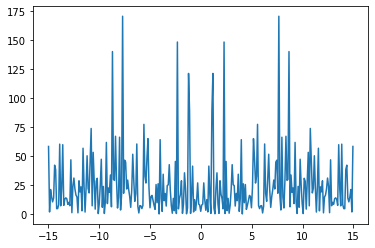

/usr/local/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 1024 is greater than input length  = 301, using nperseg = 301
  warnings.warn('nperseg = {0:d} is greater than input length '


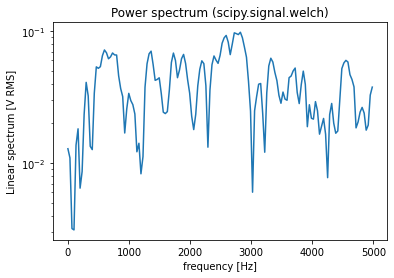

In [371]:
from scipy import signal



data = num_q

fs = 10e3



data = np.random.rand(301) - 0.5
ps = np.abs(np.fft.fft(data))**2

time_step = 1 / 30
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], ps[idx])



#plt.xticks(np.arange(0, freqs[-1] + 1, 500), rotation='vertical')
#labels = ['$\omega$', '$2 \omega$', '$4 \omega$', '$6 \omega$', '$8 \omega$', '$10 \omega$']
#plt.xticks(np.arange(0, freqs[-1] + 1, 1000), labels)
#plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
#plt.subplots_adjust(bottom=0.15)
plt.show()


# signal.welch
f, Pxx_spec = signal.welch(data, fs, 'flattop', 1024, scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.title('Power spectrum (scipy.signal.welch)')
#labels = ['$\omega$', '$2 \omega$', '$4 \omega$', '$6 \omega$', '$8 \omega$', '$10 \omega$']
#plt.xticks(np.arange(0, freqs[-1] + 1, 1000), labels)
plt.show()

/usr/local/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 1024 is greater than input length  = 160, using nperseg = 160
  warnings.warn('nperseg = {0:d} is greater than input length '


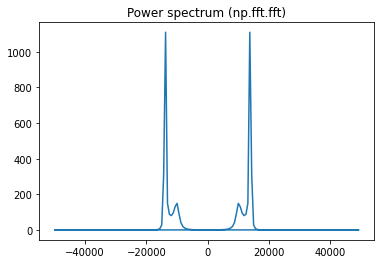

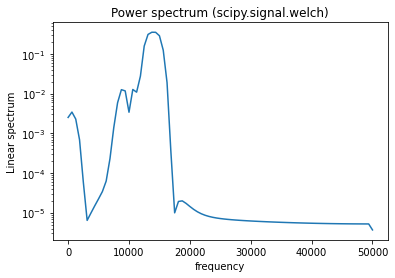

/usr/local/lib/python3.8/site-packages/scipy/signal/spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 160, using nperseg = 160
  warnings.warn('nperseg = {0:d} is greater than input length '


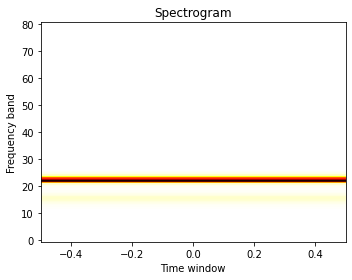

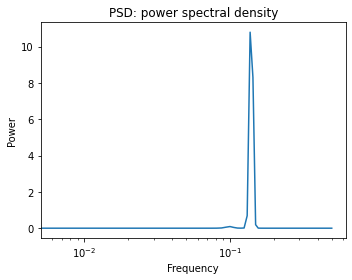

In [372]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

fs = 1e5
N = 10000

# np.fft.fft
freqs = np.fft.fftfreq(num_q.size, 1/fs)
freqs = freqs * omega**2
idx = np.argsort(freqs)
ps = np.abs(np.fft.fft(num_q))**2
plt.figure()
plt.plot(freqs, ps)
plt.title('Power spectrum (np.fft.fft)')

# signal.welch
f, Pxx_spec = signal.welch(num_q, fs, 'flattop', 1024, scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency')
plt.ylabel('Linear spectrum')
plt.title('Power spectrum (scipy.signal.welch)')
plt.show()


from scipy import signal
freqs, times, spectrogram = signal.spectrogram(num_q)

plt.figure(figsize=(5, 4))
plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')
plt.title('Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
plt.tight_layout()

freqs, psd = signal.welch(num_q)

plt.figure(figsize=(5, 4))
plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()

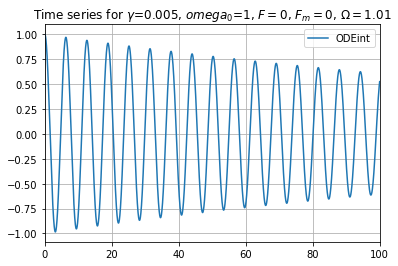

In [373]:
import numpy
x0 = 1
p0 = 0
omega = 1
gamma = 0.005
F = 0
Fm = 0
OMEGA = 1.01

T = 1 / OMEGA
k = -1
beta = 0.0


z0 = [x0, p0]
t = np.arange(0, 250, 0.01)
sol1 = odeintw(diff_eq, z0, t, atol=1e-13, rtol=1e-13, mxstep=1000)
num_q, num_p = sol1[:, 0], sol1[:, 1]
a = plt.plot(t, num_q, label='ODEint')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()
plt.xlim([0, 100])
plt.title('Time series for $\gamma$=' + str(gamma) + ', $omega_0$=' + str(omega) + ', $F=$' + str(F) +
         ', $F_m=$' + str(Fm) + ', $\Omega=$' + str(OMEGA))
plt.grid()
plt.show()

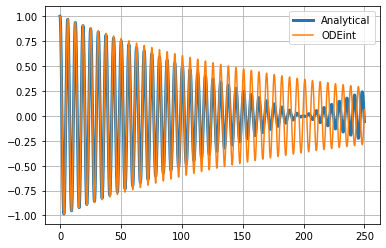

In [374]:
x0 = 1
p0 = 0
omega = 1
gamma = 0.01
F = 0.0
Fm = 0
OMEGA = 1.01
beta = 0

w0 = omega
W = OMEGA
delta = W - w0
a = np.sqrt(x0**2 + p0**2/w0**2)
PHI0 = np.arctan(-p0/x0/w0)

def x(t):
    aa = -0.5*gamma * np.sqrt(x0**2 + p0**2/w0**2)
    PHI = -3*beta*a**2/(8*w0) - F*np.sin(PHI0)
    xx = (aa*t + a)*np.cos(w0*t + PHI *t + PHI0)
    return xx

plt.plot(t, x(t), label='Analytical', lw=3)
plt.plot(t, num_q, label='ODEint')
#plt.xlim([0, 100])
#plt.ylim([-0.7,0.7])
plt.grid()
plt.legend()


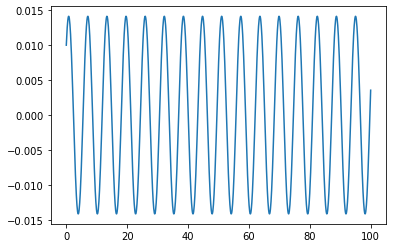

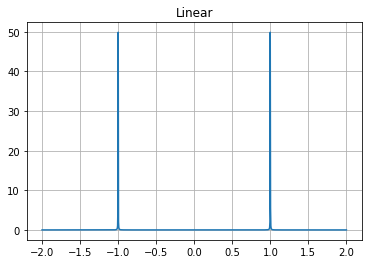

In [116]:
#  linear 
x0 = 0.01
p0 = 0.01
omega0 = 1
gamma = 0.0
F = 0.0
Fm = 0.0
OMEGA = 1.4
ww = np.linspace(-2, 2, 1000)
t = np.linspace(0, 100, 1000)
plt.plot(t, motion_analytical(t, x0, p0, omega0, gamma, F, Fm, OMEGA)[0])
plt.show()
plt.plot(ww, spectrum_density_analytical(ww, x0, p0, omega0, gamma, F, Fm, OMEGA))
plt.title('Linear')
plt.grid()

In [ ]:
#  underdamped gamma < omega0
x0 = 0.01
p0 = 0.01
omega0 = 1
gamma = 0.01
F = 0.0
Fm = 0.0
OMEGA = 1.4

t = np.linspace(0, 100, 1000)
plt.plot(t, motion_analytical(t, x0, p0, omega0, gamma, F, Fm, OMEGA)[0])
plt.show()
ww = np.linspace(-2, 2, 1000)
plt.plot(ww, spectrum_density_analytical(ww, x0, p0, omega0, gamma, F, Fm, OMEGA))
plt.title('Underdamped')
plt.grid()

In [ ]:
#  overdamped gamma > omega0
x0 = 0.01
p0 = 0.01
omega0 = 1
gamma = 1.1
F = 0.0
Fm = 0.0
OMEGA = 0

t = np.linspace(0, 100, 1000)
plt.plot(t, motion_analytical(t, x0, p0, omega0, gamma, F, Fm, OMEGA)[0])
plt.show()
ww = np.linspace(-10, 10, 1000)
plt.plot(ww, spectrum_density_analytical(ww, x0, p0, omega0, gamma, F, Fm, OMEGA))
plt.title('Overdamped')
plt.grid()

In [ ]:
#  critical gamma = omega0
x0 = 0.01
p0 = 0.01
omega0 = 1
gamma = 1
F = 0.0
Fm = 0.0
OMEGA = 0

t = np.linspace(0, 100, 1000)
plt.plot(t, motion_analytical(t, x0, p0, omega0, gamma, F, Fm, OMEGA)[0])
plt.show()
ww = np.linspace(-2, 2, 1000)
plt.plot(ww, spectrum_density_analytical(ww, x0, p0, omega0, gamma, F, Fm, OMEGA))
plt.title('Critical')
plt.grid()

In [ ]:
#  gamma < w0 with force
x0 = 0.01
p0 = 0.01
omega0 = 1
gamma = 0.01
F = 0.1
Fm = 0.0
OMEGA = 1.4

t = np.linspace(0, 100, 1000)
plt.plot(t, motion_analytical(t, x0, p0, omega0, gamma, F, Fm, OMEGA)[0])
plt.show()
ww = np.linspace(-2, 2, 1000)
plt.plot(ww, spectrum_density_analytical(ww, x0, p0, omega0, gamma, F, Fm, OMEGA))
plt.title('Underdamped forced')
plt.grid()

In [ ]:
#  gamma > w0 with force
x0 = 0.01
p0 = 0.01
omega0 = 1
gamma = 1.1
F = 0.0002
Fm = 0.0
OMEGA = 1.4

t = np.linspace(0, 100, 1000)
plt.plot(t, motion_analytical(t, x0, p0, omega0, gamma, F, Fm, OMEGA)[0])
plt.show()
ww = np.linspace(-2, 2, 1000)
plt.plot(ww, spectrum_density_analytical(ww, x0, p0, omega0, gamma, F, Fm, OMEGA))
plt.title('Overdamped forced')
plt.grid()

In [ ]:
#  gamma = w0 with force
x0 = 0.01
p0 = 0.01
omega0 = 1.0
gamma = 1.0
F = 0.0001
Fm = 0.0
OMEGA = 1.4

t = np.linspace(0, 100, 1000)
plt.plot(t, motion_analytical(t, x0, p0, omega0, gamma, F, Fm, OMEGA)[0])
plt.show()
ww = np.linspace(-2, 2, 500)
plt.plot(ww, spectrum_density_analytical(ww, x0, p0, omega0, gamma, F, Fm, OMEGA))
plt.title('Critical, forced')
plt.grid()

In [ ]:
# Underdamped gamma < w0 with two forces
x0 = 0.01
p0 = 0.01
omega0 = 1.0
gamma = 0.01

F = 0.1
Fm = 1
OMEGA = 1.4

t = np.linspace(0, 100, 1000)
plt.plot(t, motion_analytical(t, x0, p0, omega0, gamma, F, Fm, OMEGA)[0])
plt.show()
ww = np.linspace(-5, 5, 1000)
plt.plot(ww, spectrum_density_analytical(ww, x0, p0, omega0, gamma, F, Fm, OMEGA))
plt.title('Underdamped two forces')
plt.grid()

In [ ]:
# Overdamped gamma > w0 with two forces
x0 = 0.01
p0 = 0.01
omega0 = 1.0
gamma = 1.1

F = 0.002
Fm = 0.001
OMEGA = 1.4

t = np.linspace(0, 100, 1000)
plt.plot(t, motion_analytical(t, x0, p0, omega0, gamma, F, Fm, OMEGA)[0])
plt.show()
ww = np.linspace(-5, 5, 1000)
plt.plot(ww, spectrum_density_analytical(ww, x0, p0, omega0, gamma, F, Fm, OMEGA))
plt.title('Overdamped two forces')
plt.grid()

In [ ]:
# Critical gamma = w0 with two forces
x0 = 0.01
p0 = 0.01
omega0 = 1.0
gamma = 1.0

F = 0.002
Fm = 0.001
OMEGA = 1.4

t = np.linspace(0, 100, 1000)
plt.plot(t, motion_analytical(t, x0, p0, omega0, gamma, F, Fm, OMEGA)[0])
plt.show()
ww = np.linspace(-5, 5, 500)
plt.plot(ww, spectrum_density_analytical(ww, x0, p0, omega0, gamma, F, Fm, OMEGA))
plt.title('Critical two forces')
plt.grid()

In [ ]:
from scipy import signal


#  initial conditions for gamma = 0.3
#-----------------------
OMEGA = 1.4
T = 1 / OMEGA
F = 0.2
Fm = 1.0
gamma = 0.01
omega = -1.0
beta = 0.0

z0 = [0.01, 0.01]
t = np.arange(0, 300, 1e-1)

sol = odeintw(func, z0, t, atol=1e-13, rtol=1e-13, mxstep=1000)
phase_q, phase_p = sol[:,0], sol[:,1]

tleft, tright = 500, 1000

plt.figure()
plt.plot(t, phase_q)
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.title('Time series')
plt.show()

plt.figure()
plt.plot(phase_p, phase_q)
plt.xlabel(r'$t$')
plt.ylabel(r'$x$')
plt.title('Time series')
plt.show()


data = phase_q

fs = 100


# np.fft.fft
spectrum = np.fft.fft(data)
spectrum = np.abs(np.fft.fftshift(spectrum, axes=0))
# spectrum = np.abs(spectrum)
spectrum /= np.max(spectrum)

N = len(spectrum)
spectrum = spectrum[int(N/2)-1:-1]
ln = len(spectrum)
freqs = np.linspace(0, fs/2, ln)
#ps = ps[int(N/2)-1:-1]

#fig, ax = plt.subplots()
plt.plot(freqs, spectrum)
plt.xlabel('frequency [Hz]')
plt.ylabel('Spectrum')
plt.title('Power spectrum (np.fft.fft)')

#plt.xticks(np.arange(0, freqs[-1] + 1, 500), rotation='vertical')
#labels = ['$\omega$', '$2 \omega$', '$4 \omega$', '$6 \omega$', '$8 \omega$', '$10 \omega$']
#plt.xticks(np.arange(0, freqs[-1] + 1, 1000), labels)
#plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
#plt.subplots_adjust(bottom=0.15)
plt.show()


# signal.welch
f, Pxx_spec = signal.welch(data, fs, 'flattop', 1024, scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.title('Power spectrum (scipy.signal.welch)')
#labels = ['$\omega$', '$2 \omega$', '$4 \omega$', '$6 \omega$', '$8 \omega$', '$10 \omega$']
#plt.xticks(np.arange(0, freqs[-1] + 1, 1000), labels)
plt.show()

from scipy.fft import fft, fftfreq, fftshift
# number of signal points
N = 3000
# sample spacing
T = 1.0 / 8.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = phase_q
yf = fft(y)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(yf)
plt.plot(xf, 1.0/N * np.abs(yplot))
plt.grid()
plt.xlim([-2,2])
plt.show()

In [ ]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

#  initial conditions for gamma = 0.3
#-----------------------
OMEGA = 1.2
T = 1 / OMEGA
F = 0.0
m = 0.0
gamma = 0.1
omega = -1
beta = 0.0

z0 = [0.01, 0.01]
t = np.arange(0, 300, 1e-1)

sol = odeintw(func, z0, t, atol=1e-13, rtol=1e-13, mxstep=1000)
phase_q, phase_p = sol[:,0], sol[:,1]

data = phase_q
ps = np.abs(np.fft.fft(data))**2

time_step = 1 / 10
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], ps[idx])
plt.xlim([-1, 1])
plt.show()

#  linear 
x0 = 0.01
p0 = 0.01
omega0 = 1
gamma = 0.2
F = 0.0
Fm = 0.0
OMEGA = 0

ww = np.linspace(-2, 2, 1000)
plt.plot(ww, spectrum_density_analytical(ww, x0, p0, omega0, gamma, F, Fm, OMEGA))
plt.title('Linear')
plt.grid()

No handles with labels found to put in legend.


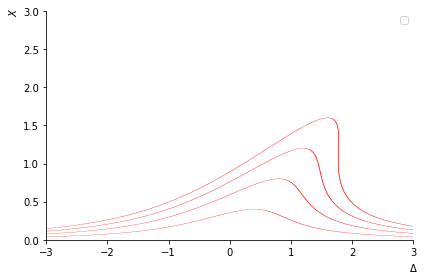

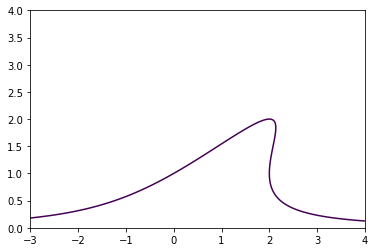

In [160]:
from sympy import symbols 
from sympy.plotting import plot
import matplotlib.pyplot as plt
import numpy as np

pp = np.arange(0.4, 1.6, 0.4)
X, y = symbols("X y")
pl = None
for p in pp:
    p1 = plot_implicit(Eq(p / ((X - y)**2 + 1), X), (y, -3, 3), (X, 0, 3),label='kjijoo', line_color='r', xlabel="$\Delta$",
                  ylabel="$X$", axis_center=(-3, 0), autoscale=False, show=False, legend=True)
    if pl:
        pl.extend(p1)
    else:
        pl = p1
pl.show()

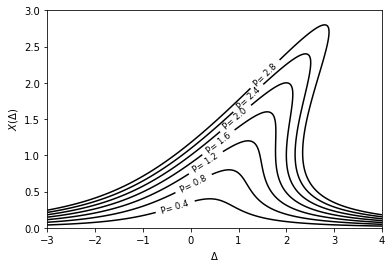

In [239]:
import matplotlib.pyplot as plt
import numpy as np

xrange = np.linspace(-3, 4, 1000)
yrange = np.linspace(0, 3, 1000)
Y, X = np.meshgrid(xrange,yrange)

# F is one side of the equation, G is the other
P = np.arange(0.4, 3.0, 0.4)

fmt = {}
strs = []
for i in range(len(P)):
    strs.append('P= %.1f' % P[i])

    
for l, p, s in zip(range(len(P)), P, strs):
    F = X
    G = p / ( (X - Y)**2 +1 )
    CS = plt.contour(Y, X, (F - G), [0], colors='k')
    fmt[l] = s
    plt.clabel(CS, inline=True, fmt=fmt[l], fontsize=8.5)
    
plt.xlabel('$\Delta$')        
plt.ylabel('$X (\Delta) $')
plt.show()